# Report
## Blur detection
##### Alexander Abugaliev

The goal of my research is classifier creation for division blurred (as a result of motion or defocus) and unblurred (clear) image regions. I have chosen this article as base solution for  the task http://www.shijianping.me/blur_cvpr14.pdf , as it represents the best approach which I have found.Moreover authors of the article appended their dataset and code, which demonstrate the classifier work: http://www.cse.cuhk.edu.hk/leojia/projects/dblurdetect/ .

In according to the article, final solution is builded from the results of 3 naive bayesian classifiers, which in its turn use 5 features, same for all classifiers. 
But this features calculated in pixel areas with different sizes (different moving window sizes), i.e. features for each pixel is calculated in different ranges around the pixel. ($11 * 11$,$15 * 15$,$21 * 21$). After that classifiers results processed by the script called multiscale interface (described in detail in the article).

The main disadvantage of this solution is classification solid color areas (blue wall for example) as blurred, although it not moving or drop out from focus. I have decided to try fix it. I'm not too strong in optics, by this reason I didn't change any features, but add one new. It based on standard deviation of saturation, I got the idea from: http://www.cse.cuhk.edu.hk/leojia/all_final_papers/blur_detect_cvpr08.pdf. The article offered to use local saturation maximum, but I didn't find any real difference between blur and solid regions in according to this feature. Instead, I use saturation deviation, also I have built histogram for this feature. As seen dispersion of the feature decreases in order clear -> blur -> solid. I suppose it could be suitable for classifier building.
<img src="./saturation_hist.png">



However, I as a machine learning specialist couldn't help but notice that naive bayes classifiers is too weak model for this task. Nowadays nobody use this model as is, because its usually has lower score in compare with other models. And firstly I have decided to replace it to my. I have built my solutions based on linear (logistic regression classifier, svm) and nonlinear (linear and logistic classifiers above polynomial features, svm with nonlinear kernels, random forest, gradient boosting). The best result has shown by the model based on gradient boosting and I replace naive bayes classifier by this model (thee models actually, one model for each patch size).

But my models didn't show so good results after interaction with multiscale interface in compare with original classifiers. I didn't measure scores, but solutions looks obviously wrong.

I started thinking, could I train classifiers based on error from multiscale interface, instead of classifier prediction error? Alas, it is too complex and large solution. Then I have decided to go another way and with help of stacking method get same result as in multiscale model. For stacking I use results of my classificators in pixel and around it ($5*5$ patch), by this way I take into account pixel context.

Few details about the classifiers. I have built 9, i.e. 3 for each size.
* first three-class classifier clear/blur/solid.
* second two-class classifier clear/blur.
* third two-class classifier nonsolid/solid.
As the sum of classes probabilities should be equal 1, first classifier more careful in decisions, in compare with other two. Above them I build 2 stacking classifiers, first above clear/blur/solid classifiers and second above clear/blur results and solid probabilities from nonsolid/solid classifire, hereinafter it called clear/blur+solid.

Let's analyze results.

# Statistical scores (througth all images)

### Accuracy

In [11]:
accuracy_scores_base = []
accuracy_scores_cbs = []
accuracy_scores_cbps = []
for target in dirlist:
    prediction = get_predictions(target)
    precision_gt = (np.array(prediction[4].reshape(1,prediction[4].shape[0]*prediction[4].shape[1]).tolist()[0])/255).round()
    precision_base = np.array(prediction[3].reshape(1,prediction[4].shape[0]*prediction[3].shape[1]).tolist()[0])>0.5
    precision_cbs = np.array(prediction[1].reshape(1,prediction[1].shape[0]*prediction[1].shape[1]).tolist()[0])>0.5
    precision_cbps = np.array(prediction[2].reshape(1,prediction[2].shape[0]*prediction[2].shape[1]).tolist()[0])>0.5
    accuracy_scores_base.append(accuracy_score(precision_gt,precision_base))
    accuracy_scores_cbs.append(accuracy_score(precision_gt,precision_cbs))
    accuracy_scores_cbps.append(accuracy_score(precision_gt,precision_cbps))

KeyboardInterrupt: 

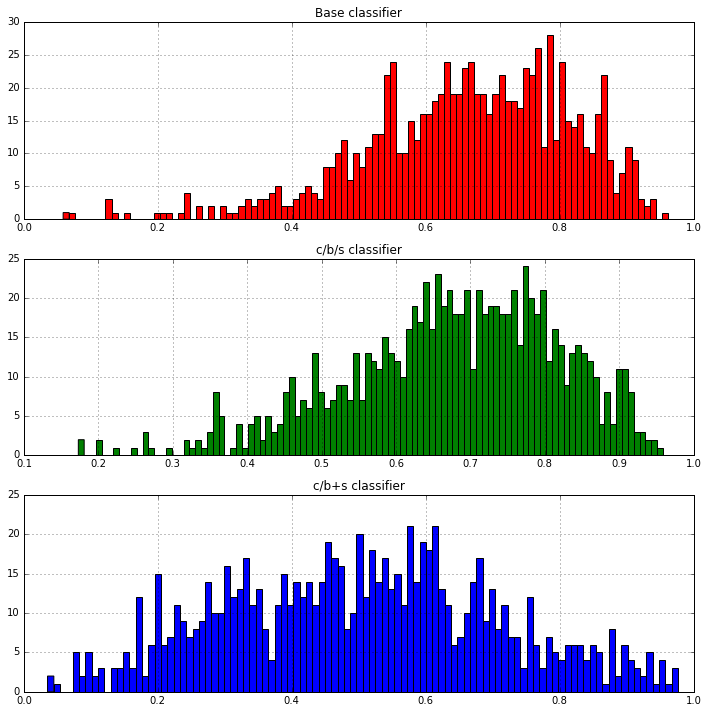

In [12]:
plt.figure(2,figsize=(12,12))
plt.subplot(311)
plt.title('Base classifier')
plt.hist(accuracy_scores_base,color='red',bins=100)
plt.grid()
plt.subplot(312)
plt.title('c/b/s classifier')
plt.hist(accuracy_scores_cbs,color='green',bins=100)
plt.grid()
plt.subplot(313)
plt.title('c/b+s classifier')
plt.hist(accuracy_scores_cbps,color='blue',bins=100)
plt.grid()

t-criteria for mean

In [ ]:
u = np.mean(accuracy_scores_base)
S = np.std(accuracy_scores_base,ddof=1)/np.sqrt(len(accuracy_scores_base))
interval = _tconfint_generic(u,S,len(accuracy_scores_base)-1,0.05,'two-sided')
print('Mean accuracy for base classifier in ', interval,' with p-value 0.05')

In [ ]:
u = np.mean(accuracy_scores_cbs)
S = np.std(accuracy_scores_cbs,ddof=1)/np.sqrt(len(accuracy_scores_cbs))
interval = _tconfint_generic(u,S,len(accuracy_scores_cbs)-1,0.05,'two-sided')
print('Mean accuracy for c/b/s classifier in ', interval,' with p-value 0.05')

In [ ]:
u = np.mean(accuracy_scores_cbps)
S = np.std(accuracy_scores_cbps,ddof=1)/np.sqrt(len(accuracy_scores_cbps))
interval = _tconfint_generic(u,S,len(accuracy_scores_cbps)-1,0.05,'two-sided')
print('Mean accuracy for c/b+s classifier in ', interval,' with p-value 0.05')

### ROC_AUC

In [ ]:
roc_auc_scores_base = []
roc_auc_scores_cbs = []
roc_auc_scores_cbps = []
for target in dirlist:
    prediction = get_predictions(target)
    precision_gt = (np.array(prediction[4].reshape(1,prediction[4].shape[0]*prediction[4].shape[1]).tolist()[0])/255).round()
    precision_base = np.array(prediction[3].reshape(1,prediction[4].shape[0]*prediction[3].shape[1]).tolist()[0])>0.5
    precision_cbs = np.array(prediction[1].reshape(1,prediction[1].shape[0]*prediction[1].shape[1]).tolist()[0])>0.5
    precision_cbps = np.array(prediction[2].reshape(1,prediction[2].shape[0]*prediction[2].shape[1]).tolist()[0])>0.5
    roc_auc_scores_base.append(roc_auc_score(precision_gt,precision_base))
    roc_auc_scores_cbs.append(roc_auc_score(precision_gt,precision_cbs))
    roc_auc_scores_cbps.append(roc_auc_score(precision_gt,precision_cbps))

In [ ]:
plt.figure(2,figsize=(12,12))
plt.subplot(311)
plt.title('Base classifier')
plt.hist(roc_auc_scores_base,color='red',bins=100)
plt.grid()
plt.subplot(312)
plt.title('c/b/s classifier')
plt.hist(roc_auc_scores_cbs,color='green',bins=100)
plt.grid()
plt.subplot(313)
plt.title('c/b+s classifier')
plt.hist(roc_auc_scores_cbps,color='blue',bins=100)
plt.grid()

In [ ]:
u = np.mean(roc_auc_scores_base)
S = np.std(roc_auc_scores_base,ddof=1)/np.sqrt(len(roc_auc_scores_base))
interval = _tconfint_generic(u,S,len(roc_auc_scores_base)-1,0.05,'two-sided')
print('Mean accuracy for base classifier in ', interval,' with p-value 0.05')

In [ ]:
u = np.mean(roc_auc_scores_cbs)
S = np.std(roc_auc_scores_cbs,ddof=1)/np.sqrt(len(roc_auc_scores_cbs))
interval = _tconfint_generic(u,S,len(roc_auc_scores_cbs)-1,0.05,'two-sided')
print('Mean accuracy for c/b/s classifier in ', interval,' with p-value 0.05')

In [ ]:
u = np.mean(roc_auc_scores_cbps)
S = np.std(roc_auc_scores_cbps,ddof=1)/np.sqrt(len(roc_auc_scores_cbps))
interval = _tconfint_generic(u,S,len(roc_auc_scores_cbps)-1,0.05,'two-sided')
print('Mean accuracy for c/b+s classifier in ', interval,' with p-value 0.05')

# Examples

In [ ]:
show_predictions('motion0012')

In [ ]:
show_predictions('out_of_focus0303')

In [ ]:
show_predictions('out_of_focus0385')

In [ ]:
show_predictions('out_of_focus0407')

In [ ]:
show_predictions('motion0009')

In [ ]:
show_predictions('out_of_focus0026')

In [ ]:
show_predictions('motion0071')

# Conclusion

As a result of the work I was not able to create a classifier, for effective separation blurred and solid color image regions, that pushes to the idea of objects space indivisibility in this feature space. Moreover features histograms indicate it (I dont apply it in the report, but I will send them, if it necessary). Although it is possible they can be divided using context information (surrounding) pixels, for this I can try to use a convolutional neural network, feeding to the input not only the original image, but these features too. Thereby forming the 7 layers (original image in grayscale + 6 features) image on the input layer. Promising of this embodiment is U-net network uses 3 convolutional layers and thereby obtaining information about pixel context in radius of 27 pixels at least.
Nevertheless, presented solution is adequately better (in according with scores) than presented in base article.

# Service functions

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score, precision_recall_curve
from statsmodels.stats.weightstats import _tconfint_generic
from scipy import misc
import pickle
import os
import cv2
from sklearn.cluster import KMeans
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
dirlist = os.listdir('./extracted')[:1000]

In [3]:
FIRST_KERNEL_SIZE = 21
SECOND_KERNEL_SIZE = 5
N_COLOURS = 8
THRESHOLD = 0.0001
COLOR_SOLID = 0
COLOR_BLUR = 1
COLOR_CLEAR = 0
SMOOTH_KERNEL_SIZE = 8

In [4]:
def get_solid_color_mask(image):
    first_kernel = get_kernel(FIRST_KERNEL_SIZE)
    second_kernel = get_kernel(SECOND_KERNEL_SIZE)
    clustered_image = reduce_color_count(image,N_COLOURS)    
    blurred_clustered_image = cv2.filter2D(clustered_image,-1,first_kernel)
    clustered_images_difference = (np.sum((np.abs(clustered_image - blurred_clustered_image))/3.0,axis=2)).astype(float)
    #smoothing
    solid_color_areas  = cv2.filter2D(clustered_images_difference,-1,second_kernel)
    #normalisation
    solid_color_areas = (solid_color_areas - np.min(solid_color_areas))/np.max(solid_color_areas)
    #edges restoration
    solid_color_areas = 1-np.arctan(solid_color_areas/THRESHOLD)
    return solid_color_areas

In [5]:
def choose_area_type_cbs(blur_score,solid_score):
    if solid_score > 0.5:
        return COLOR_SOLID
    if blur_score> 0.7:
        return COLOR_BLUR
    else:
        return COLOR_CLEAR

def choose_area_type_cb_s(blur_score,solid_score):
    if solid_score > 0.5:
        return COLOR_SOLID
    if blur_score> 0.9:
        return COLOR_BLUR
    else:
        return COLOR_CLEAR

def mark_solid_colour_areas_cbs(blur_prediction,solid_prediction):
    return np.array(list(map(choose_area_type_cbs,blur_prediction,solid_prediction)))

def mark_solid_colour_areas_cb_s(blur_prediction,solid_prediction):
    return np.array(list(map(choose_area_type_cb_s,blur_prediction,solid_prediction)))

In [6]:
def get_kernel(size):
    return np.ones((size,size),np.float32)/(size**2)

In [7]:
def reduce_color_count(image,n_colours):
    im_heigth = image.shape[0]
    im_width = image.shape[1]
    KM = KMeans(n_clusters=n_colours,init='k-means++')
    image2 = KM.fit_predict(image.reshape((im_heigth*im_width,image.shape[2])))
    image2 = np.array(list(map(lambda x: KM.cluster_centers_[x],image2)))
    image2 = image2.reshape((im_heigth,im_width,3))
    return 255 - image2.astype(int)

In [8]:
def get_predictions(target):
    predictions = pickle.load(open('./extracted/'+target+'/predictions.bin','rb'))
    mask = get_solid_color_mask(predictions[0])
    predictions_cbs = np.array(list(map(mark_solid_colour_areas_cbs,predictions[1],mask)))
    predictions_cb_s = np.array(list(map(mark_solid_colour_areas_cb_s,predictions[2],mask)))
    predictions = (predictions[0],predictions_cbs,predictions_cb_s,predictions[3],predictions[4])
    return predictions

In [9]:
def show_predictions(target):
    predictions = get_predictions(target)
    fig, axes = plt.subplots(1,5,figsize=(20,20))
    axes[0].imshow(predictions[0])
    axes[0].set_title('original')
    axes[1].imshow(predictions[1],cmap='gray')
    axes[1].set_title('c/b/s classifier')
    axes[2].imshow(predictions[2],cmap='gray')
    axes[2].set_title('c/b+s classifier')
    axes[3].imshow(predictions[3],cmap='gray')
    axes[3].set_title('base classifier')
    axes[4].imshow(predictions[4],cmap='gray')
    axes[4].set_title('ground truth')